# Creating the input database for ecPoint-Calibrate

### What does this Jupyter notebook?
This Jupyter notebook will generate the input database, for forecasts and observations, in the format required by ecPoint-Calibrate.

### What raw forecasts will be used?
The raw forecasts that will be used in this Jupyter notebook come from form the Integrated Forecasting System (IFS) of the European Centre for Medium-range Weather Forecasts (ECMWF). The forecasts come from an experiment run to create forecasts with the the 47r1 version of the IFS, for a period between January 1st and December 31st, 2019. The forecasts are provided in grib format.

### What raw observations will be used used?
The raw observations used in this software are the "Global Surface Summary of Day" product produced by the NOAA's National Centers for Environmental Information (NCEI). The observations are freely downloadable from https://www.ncei.noaa.gov/data/global-summary-of-the-day/archive/ and are processed with pandas and Metview (https://pypi.org/project/metview/). From all the parameters in the raw files, this Jupyter notebook will use only:
1. Precipitation amount for 24 hours, PRCP (.01 inches)
2. Mean temperature over 24 hours, TEMP (.1 Fahrenheit)
The observations will be converted in geopoints, and the units will get converted in mm for precipitation, and Celsius degrees for temperature.

NOTE: each file contains all the observations for the year at a specific station
_______________________________________________________________________________________________________________________________

## Setting the environment

In [2]:
import os
import fileinput
from datetime import date, datetime, timedelta
import numpy as np
import pandas as pd
import metview as mv

In [3]:
# INPUT PARAMETERS
DateS = date(2019, 1, 1)
DateF = date(2019, 1, 1)
Delta_Date = timedelta(days=1)
WorkDir = os.path.dirname(os.getcwd())
RawData_Dir = "RawData"
InputDB_Dir = "InputDB" 
FC_Dir = "FC"
OBS_Dir = "OBS"

In [4]:
# CREATING SOME ENVIRONMENT VARIABLES
RawData_FC_Dir = WorkDir + "/" + RawData_Dir + "/" + FC_Dir
RawData_OBS_Dir = WorkDir + "/" + RawData_Dir + "/" + OBS_Dir
InputDB_prcp_Dir = WorkDir + "/" + InputDB_Dir + "/Rainfall"
InputDB_temp_Dir = WorkDir + "/" + InputDB_Dir + "/Temperature"
InputDB_prcp_FC_Dir = InputDB_prcp_Dir + "/" + FC_Dir
InputDB_prcp_OBS_Dir = InputDB_prcp_Dir + "/" + OBS_Dir
InputDB_temp_FC_Dir = InputDB_temp_Dir + "/" + FC_Dir
InputDB_temp_OBS_Dir = InputDB_temp_Dir + "/" + OBS_Dir

## Create the InputDB for observations

In [5]:
# List all the raw observation files in the directory "RawData_OBS_Dir"
arr = os.listdir(RawData_OBS_Dir)
print("NOTE:")
print("There are " + str(len(arr)) + " stations around the globe to analyse.")

# Begining of the observations pre-processing
# NOTE: each day of the year will be pre-process at a time
TheDate = DateS
while TheDate <= DateF:
    
    TheDateSTR = TheDate.strftime("%Y-%m-%d")
    print(" ")
    print("Pre-Processing observations for " + TheDateSTR)
    now = datetime.now()
    print("Starting at... ", now.strftime("%H:%M:%S"))
    
    # Generating empty dataframes for each day of the year
    df_prcp = pd.DataFrame()
    df_temp = pd.DataFrame()
    
    for RawData_OBS_Filename in arr:
        
        # Read the raw observations for each station
        RawData_OBS_File = RawData_OBS_Dir + "/" + RawData_OBS_Filename
        df = pd.read_csv(RawData_OBS_File)
        df1 = df[df["DATE"].isin([TheDateSTR])] #selection of the date of interest
        
        # Pre-processing of precipitation observations
        df1_prcp = df1[["STATION", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "PRCP", "PRCP_ATTRIBUTES"]]
        frames = [df_prcp, df1_prcp]
        df_prcp = pd.concat(frames)
          
        # Pre-processing of temperature observations
        df1_temp = df1[["STATION", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", "TEMP", "TEMP_ATTRIBUTES"]]
        frames = [df_temp, df1_temp]
        df_temp = pd.concat(frames)

    # Pre-processing of precipitation observations
    df_prcp = df_prcp[df_prcp.PRCP != 99.99] # eliminating the missing values
    df_prcp = df_prcp[df_prcp.PRCP_ATTRIBUTES != "A"] # eliminating the stations that reported only 1 report of 6-hour precipitation amount.
    df_prcp = df_prcp[df_prcp.PRCP_ATTRIBUTES != "B"] # eliminating the stations that reported only the summation of 2 reports of 6-hour precipitation amount.
    df_prcp = df_prcp[df_prcp.PRCP_ATTRIBUTES != "C"] # eliminating the stations that reported only the summation of 3 reports of 6-hour precipitation amount.
    df_prcp = df_prcp[df_prcp.PRCP_ATTRIBUTES != "E"] # eliminating the stations that reported only 1 report of 12-hour precipitation amount.
    df_prcp = df_prcp[df_prcp.PRCP_ATTRIBUTES != "H"] # eliminating the stations that reported incomplete data for the day.
    df_prcp = df_prcp[df_prcp.PRCP_ATTRIBUTES != "I"] # eliminating the stations that did not report any precipitation data for the day.
    df_prcp["PRCP"] = df_prcp["PRCP"] * 25.4 # converting rainfall in mm from inches.
    del df_prcp['PRCP_ATTRIBUTES'] # eliminate the "PRCS_ATTRIBUTES" column from the final output
    df_prcp.rename(columns={"STATION":"stnid","LATITUDE":"latitude","LONGITUDE":"longitude","ELEVATION":"level","DATE":"date","PRCP":"value_0"}, inplace=True) # changing the name of the dataframe columns
    df_prcp.insert (5, "time", 0) # adding "time" column
    df_prcp["date"] = pd.to_datetime(df_prcp["date"]).dt.strftime('%Y%m%d') # change date format
    print("Total n. of rainfall observations maintained: " + str(len(df_prcp)))
    
    # Pre-processing of temperature observations
    df_temp = df_temp[df_temp.TEMP != 9999.9] # eliminating the missing values.
    df_temp = df_temp[df_temp.TEMP_ATTRIBUTES >= 20] # eliminating those reports that did not provide hourly observations for at least 20 hours in the day.
    df_temp["TEMP"] = (df_temp["TEMP"] - 32) * (5/9) # converting temperature in Celsius from Farenheit degrees.
    del df_temp['TEMP_ATTRIBUTES'] # eliminate the "TEMP_ATTRIBUTES" column from the final output
    df_temp.rename(columns={"STATION":"stnid","LATITUDE":"latitude","LONGITUDE":"longitude","ELEVATION":"level","DATE":"date","PRCP":"value_0"}, inplace=True) # changing the name of the dataframe columns
    df_temp.insert (5, "time", 0) # adding "time" column
    df_temp["date"] = pd.to_datetime(df_temp["date"]).dt.strftime('%Y%m%d') # change date format
    print("Total n. of temperature observations maintained: " + str(len(df_temp)))
    
    TheDate += Delta_Date

    now = datetime.now()
    print("Ending at... ", now.strftime("%H:%M:%S"))

NOTE:
There are 12352 stations around the globe to analyse.
 
Pre-Processing observations for 2019-01-01
Starting at...  23:20:36
Total n. of rainfall observations maintained: 5772
Total n. of temperature observations maintained: 6770
Ending at...  23:23:32


In [17]:
# Saving the .csv files for each day of the year
TheDate_File = TheDate + timedelta(days=1)
TheDateSTR_File = TheDate_File.strftime("%Y%m%d")

# Rainfall
InputDB_prcp_OBS_Dir_temp = InputDB_prcp_OBS_Dir + "/" + TheDateSTR_File
if not os.path.exists(InputDB_prcp_OBS_Dir_temp):
    os.makedirs(InputDB_prcp_OBS_Dir_temp)
InputDB_prcp_OBS_File = InputDB_prcp_OBS_Dir_temp + "/" + TheDateSTR_File + "00.csv"
df_prcp.to_csv(InputDB_prcp_OBS_File, index=False, sep='\t')


# Temperature
InputDB_temp_OBS_Dir_temp = InputDB_temp_OBS_Dir + "/" + TheDateSTR_File
if not os.path.exists(InputDB_temp_OBS_Dir_temp):
    os.makedirs(InputDB_temp_OBS_Dir_temp)
InputDB_temp_OBS_File = InputDB_temp_OBS_Dir_temp + "/" + TheDateSTR_File + "00.csv"
df_temp.to_csv(InputDB_temp_OBS_File, index=False, sep='\t')

In [26]:
inFile = open(InputDB_prcp_OBS_File)
outFile = open("result.txt", "w")
buffer = []
keepCurrentSet = True
for line in inFile:
    buffer.append(line)
headers = buffer[0]

stnid	latitude	longitude	level	date	time	value_0



In [32]:
outfilename = InputDB_prcp_OBS_File = InputDB_prcp_OBS_Dir_temp + "/" + "Header.txt"
outF = open(outfilename, "w")
outF.write("#GEO")
outF.write("\n")
outF.write("#FORMAT NCOLS")
outF.write("\n")
outF.write("#COLUMNS")
outF.write("\n")
outF.write(headers)
outF.write("# Missing values represented by 3e+38 (not user-changeable)")
outF.write("\n")
outF.write("#METADATA")
outF.write("\n")
outF.write("date=" + TheDateSTR_File)
outF.write("\n")
outF.write("level=0")
outF.write("\n")
outF.write("param=tp")
outF.write("\n")
outF.write("parameter=tp")
outF.write("\n")
outF.write("period=43200")
outF.write("\n")
outF.write("step=0")
outF.write("\n")
outF.write("time=0000")
outF.write("\n")
outF.write("units=mm")
outF.write("\n")
outF.write("#DATA")
outF.write("\n")
outF.close()

In [34]:
header = InputDB_prcp_OBS_File = InputDB_prcp_OBS_Dir_temp + "/" + "Header.txt"
InputDB_prcp_OBS_File = InputDB_prcp_OBS_Dir_temp + "/" + TheDateSTR_File + "00.csv"
filenames = [header,InputDB_prcp_OBS_File]
InputDB_prcp_OBS_File = InputDB_prcp_OBS_Dir_temp + "/" + TheDateSTR_File + "00.geo"
with open(InputDB_prcp_OBS_File, 'w') as fout, fileinput.input(filenames) as fin:
    for line in fin:
        fout.write(line)

In [12]:
# Creation of the geopoints
stids = df_prcp["STATION"].to_numpy() 
lats = df_prcp["LATITUDE"].to_numpy() 
lons = df_prcp["LONGITUDE"].to_numpy() 
vals = df_prcp["PRCP"].to_numpy() 
g = mv.create_geo(type       = "standard",
                  latitudes  =  lats,
                  longitudes = lons,
                  values    = vals
                  )

# Saving the geopoints
TheDate_File = TheDate + timedelta(days=1)
TheDateSTR_File = TheDate_File.strftime("%Y%m%d")
InputDB_prcp_OBS_Dir_temp = InputDB_prcp_OBS_Dir + "/" + TheDateSTR_File
if not os.path.exists(InputDB_prcp_OBS_Dir_temp):
    os.makedirs(InputDB_prcp_OBS_Dir_temp)
InputDB_prcp_OBS_File = InputDB_prcp_OBS_Dir_temp + "/" + TheDateSTR_File + "00.geo"
mv.write(InputDB_prcp_OBS_File,g)

0.0

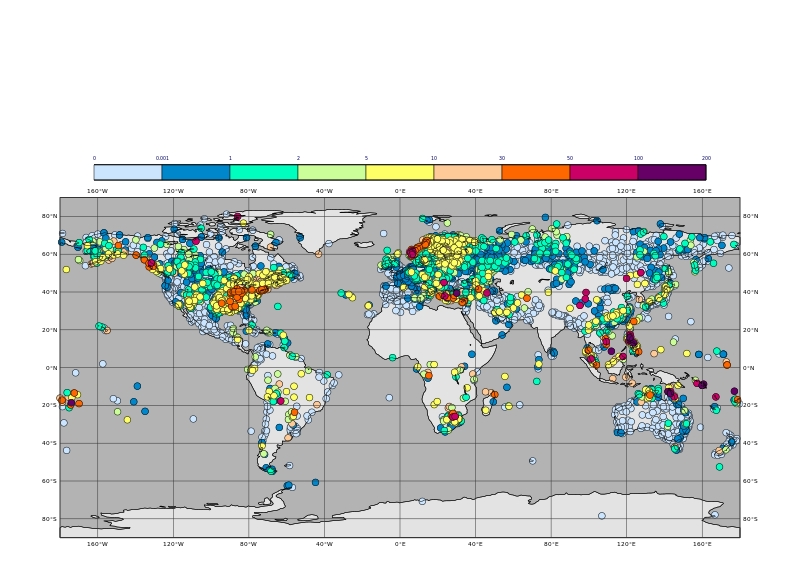

In [68]:
# To display plots within the Jupyter notebook
mv.setoutput("jupyter")

my_coast = mv.mcoast(
    map_coastline_land_shade        = "on",
    map_coastline_land_shade_colour = "RGB(0.89,0.89,0.89)",
    map_coastline_sea_shade         = "on",
    map_coastline_sea_shade_colour  = "grey",
    map_grid_latitude_increment     = 20,
    map_grid_longitude_increment    = 40,
    map_grid_colour                 = "charcoal"
    )

my_symbol = mv.msymb(
    legend                               = "on",
    symbol_type                          = "marker",
    symbol_marker_index                  = 15,
    symbol_table_mode                    = "advanced",
    symbol_outline                       = "on",
    symbol_advanced_table_selection_type = "list",
    symbol_advanced_table_level_list     = [0,0.001,1,2,5,10,30,50,100,200],
    symbol_advanced_table_colour_method  = "list",
    symbol_advanced_table_colour_list    = ["rgb(204, 230, 255)","rgb(0, 136, 204)","rgb(0, 255, 191)","rgb(204, 255, 153)","rgb(255, 255, 102)","rgb(255, 204, 153)","rgb(255, 102, 0)","rgb(204, 0, 102)","rgb(102, 0, 102)"],
    symbol_advanced_table_height_list    = 0.5
)

# Plot
mv.plot(my_coast,my_symbol,g)